In [1]:
# Summary -
# - There are totally 59K touch gestures.
# - Only ~22K (37%) touch gestures was clicked on a leaf element which had text content.
# - Created text dataset in the following format
#   - [[e11, e21, ... e1(MAX_TOKEN), e21, e22, ... e2(MAX_TOKEN), TARGET_TEXT],
#      ...
#     ]
#   - Vectorized the dataset.
# - Tried a simple classification model with a single hidden layer(1024).
#   - Accuracy on train data : 48%
#   - Accuracy on validation (20%) : 50%

In [2]:
# import statements.
import datetime
import glob
import json
import numpy as np
import os
import PIL
import tensorflow as tf
import re
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Constants.
LONG_TOUCH_THRESHOLD = 5
DIM_X = 1440
DIM_Y = 2560
MAX_TOKEN = 64
BATCH_SIZE = 100
BUFFER_SIZE = 100
VOCAB_SIZE = 100
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
TRACES_PATH = 'filtered_traces/*/*'
NEGATIVE_SAMPLE_TARGET = '[null]'
PLACEHOLDER_TEXT = 'n/a'

In [4]:
# Gets all leaf nodes for a given element.
def get_leaf_nodes(element, leaf_nodes):
    if not element:
        return leaf_nodes
    if 'children' not in element:
        leaf_nodes.append(element)
        return leaf_nodes
    for child in element['children']:
        get_leaf_nodes(child, leaf_nodes)
    return leaf_nodes


def get_all_leaf_nodes(view_hierarchy_json):
    activity = view_hierarchy_json.get('activity')
    if not activity:
        return dataset
    root = activity.get('root')
    return get_leaf_nodes(root, [])


def get_target_text(leaf_nodes, x, y):
    target_text = None
    for leaf_node in leaf_nodes:
        bounds = leaf_node['bounds']
        if bounds[0] <= x and bounds[2] >= x and bounds[1] <= y and bounds[3] >= y:
            if 'text' in leaf_node:
                target_text = leaf_node['text'] or leaf_node.get('text-hint')
    return target_text


def get_leaf_node_features(leaf_nodes):
    i = 1
    element_features = []
    for leaf_node in leaf_nodes:
        if 'text' in leaf_node:
            text = leaf_node['text'] or leaf_node.get('text-hint')
            _class = leaf_node['class']
            element_features.append(str(text))
            element_features.append(str(_class))
            i += 1
            if i == MAX_TOKEN:
                break
    return element_features



# Identifies if a given gesture is a TOUCH gesture.
# In this task, we will only be focussing on TOUCH gestures.
def is_touch_gesture(gesture):
    if len(gesture) <= LONG_TOUCH_THRESHOLD:
        return True
    return False

In [5]:
dirs = glob.glob(TRACES_PATH)
touch_gesture_count = 0
non_touch_gesture_count = 0
for d in dirs:
  with open(f'{d}/gestures.json') as f:
    gestures = json.load(f)
    gestures = [gestures[x] for x in sorted(gestures, key=lambda x: int(x))]
    for gesture in gestures:
        if is_touch_gesture(gesture):
            touch_gesture_count += 1
        else:
            non_touch_gesture_count += 1
print('Number of touch gestures ', touch_gesture_count)
print('Number of non-touch gestures ', non_touch_gesture_count)

Number of touch gestures  59602
Number of non-touch gestures  6659


In [6]:
# Processes view hierarchies to construct dataset.
# Extract texts from MAX_TOKEN elements from both view hierarchies.
# Construct the dataset in the following format -
# [[e11, e21, ... e1(MAX_TOKEN), e21, e22, ... e2(MAX_TOKEN), TARGET_TEXT], ...]

def get_features(leaf_nodes1, leaf_nodes2):
    screen1_features = get_leaf_node_features(leaf_nodes1)
    screen2_features = get_leaf_node_features(leaf_nodes2)

    for i in range(int(len(screen1_features) / 2), MAX_TOKEN):
        screen1_features.append(PLACEHOLDER_TEXT)  # Element Text.
        screen1_features.append(PLACEHOLDER_TEXT)  # Element Class.
    for i in range(int(len(screen2_features) / 2), MAX_TOKEN):
        screen2_features.append(PLACEHOLDER_TEXT)  # Element Text.
        screen1_features.append(PLACEHOLDER_TEXT)  # Element Class.
    
    return screen1_features, screen2_features


def process_view_hierarchy(view_hierarchy1, view_hierarchy2, dataset, is_positive_sample = True):
    if not view_hierarchy1 or not view_hierarchy2:
        return dataset
    
    trace_path = view_hierarchy1.split('view_hierarchies')[0]
    gesture_path = f'{trace_path}/gestures.json'
    with open(gesture_path) as file:
        gestures = json.load(file)

    with open(view_hierarchy1) as file:
        view_hierarchy1_json = json.load(file)
    with open(view_hierarchy2) as file:
        view_hierarchy2_json = json.load(file)
    
    if not view_hierarchy1_json or not view_hierarchy2_json:
        return dataset

    ui_number = view_hierarchy1.split('/')[-1].split('.')[0]
    gesture = gestures[ui_number]
    if not is_touch_gesture(gesture):
        return dataset
    
    if not len(gesture):
        return dataset
    x_cord = gesture[0][0]
    y_cord = gesture[0][1]
    x = x_cord * DIM_X
    y = y_cord * DIM_Y

    leaf_nodes1 = get_all_leaf_nodes(view_hierarchy1_json)
    leaf_nodes2 = get_all_leaf_nodes(view_hierarchy2_json)

    target_text = get_target_text(leaf_nodes1, x, y)
    if not target_text:
        return dataset
    
    screen1_features, screen2_features = get_features(leaf_nodes1, leaf_nodes2)

    if is_positive_sample:
        dataset.append(screen1_features + screen2_features + [target_text])
    else:
        dataset.append(screen1_features + screen2_features + [NEGATIVE_SAMPLE_TARGET])
    return dataset
        

def process_trace(trace_path, dataset):
    view_hierarchies_path = f'{trace_path}/view_hierarchies/*'
    view_hierarchies = sorted(glob.glob(view_hierarchies_path))
    for i in range(len(view_hierarchies) - 1):
        dataset = process_view_hierarchy(view_hierarchies[i], view_hierarchies[i+1], dataset)


def add_negative_samples(dataset):
    traces = sorted(glob.glob(TRACES_PATH))
    total_positive_samples = len(dataset)
    negative_samples_threshold = 0.1 * total_positive_samples
    negative_samples_counter = 0
    for i in range(len(traces) - 1):
        trace_path1 = traces[i]
        trace_path2 = traces[i+1]
        view_hierarchies1_path = sorted(glob.glob(f'{trace_path1}/view_hierarchies/*'))
        view_hierarchies2_path = sorted(glob.glob(f'{trace_path2}/view_hierarchies/*'))
        for (view_hierarchy1, view_hierarchy2) in zip(view_hierarchies1_path, view_hierarchies2_path):
            dataset = process_view_hierarchy(view_hierarchy1, view_hierarchy2, dataset, False)
            negative_samples_counter += 1
            if negative_samples_counter >= negative_samples_threshold:
                break
    return dataset


dataset = []
for trace_path in sorted(glob.glob(TRACES_PATH)):
    process_trace(trace_path, dataset)

dataset = add_negative_samples(dataset)

In [7]:
total_positive_samples = len(dataset)
negative_samples_threshold = 0.1 * total_positive_samples
negative_samples_threshold

2609.6000000000004

In [8]:
targets = []
for row in dataset:
    targets.append(re.sub('[%s]' % re.escape(string.punctuation), '', row[-1].lower()))

In [9]:
# We create a custom standardization function to lowercase the text and 
# remove punctuation.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  lowercase = tf.strings.regex_replace(lowercase, '\s', '')
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')

# Define the number of words in a sequence.
sequence_length = 1

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    standardize=custom_standardization,
    output_mode='int',
    output_sequence_length=sequence_length)

all_words = []
for row in dataset:
    for word in row:
        all_words.append(str(word))
unique_words = set(all_words)
print('unique_words = ',len(unique_words))
vectorize_layer.adapt(list(unique_words))

unique_words =  198026


In [10]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])
len(inverse_vocab)

['', '[UNK]', '1', '0', '10', '000', '00', '11', '100', '2', '12', '20', '15', '5', '4', '3', 'signup', '21', '14', '13']


177303

In [11]:
y_true = []
c = 0
t = 0
for target in targets:
    t += 1
    if target in inverse_vocab:
        c += 1
        y_true.append(inverse_vocab.index(target))
    else:
        y_true.append(-1)
print(c, ' and ', t)

15728  and  26096


In [12]:
# Vectorize the data.
text_ds = tf.data.Dataset.from_tensor_slices(dataset)
text_vector_ds = text_ds.map(vectorize_layer)

In [13]:
sequences = list(text_vector_ds.as_numpy_iterator())
sequences = np.squeeze(sequences)

for seq in sequences[:5]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[    64 151389 114991 151389 122689 151389    296 151403 114993 151389
 122690 151389    296 151403    217 151389  93014 151389    296 151389
 148299 151404  58968 151404  51663 151404  54072 151389    296 151389
    298    298    298    298    298    298    298    298    298    298
    298    298    298    298    298    298    298    298    298    298
    298    298    298    298    298    298    298    298    298    298
    298    298    298    298    298    298    298    298    298    298
    298    298    298    298    298    298    298    298    298    298
    298    298    298    298    298    298    298    298    298    298
    298    298    298    298    298    298    298    298    298    298
    298    298    298    298    298    298    298    298    298    298
    298    298    298    298    298    298    298    298    298    298
    298    298    298    298    298    298    298    298    298    298
    298    298    298    298    298    298    298    298    298    298
    29

In [14]:
def map_to_dataset(sequences, inverse_vocab):
    num_ns = len(inverse_vocab)
    labels = []
    input_data = []
    for input_instance in sequences:
        y = input_instance[-1:]
        labels.append(y)
        input_data.append(input_instance[:-1])
    categorized_labels = tf.keras.utils.to_categorical(labels, num_ns)
    return tf.data.Dataset.from_tensor_slices((input_data, categorized_labels))

In [15]:
train, test = train_test_split(sequences, test_size=TEST_SIZE)
train, val = train_test_split(sequences, test_size=VAL_SIZE)

In [16]:
train = map_to_dataset(train, inverse_vocab).batch(BATCH_SIZE)
val = map_to_dataset(val, inverse_vocab).batch(BATCH_SIZE)
test = map_to_dataset(test, inverse_vocab).batch(BATCH_SIZE)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(MAX_TOKEN*4, )),
    tf.keras.layers.Embedding(
        input_dim=len(inverse_vocab),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(inverse_vocab), activation='softmax')
])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train, validation_data=val, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
235/235 [==============================] - 217s 922ms/step - loss: 12.0856 - accuracy: 0.1612 - val_loss: 12.0856 - val_accuracy: 0.1579
Epoch 2/10
235/235 [==============================] - 216s 919ms/step - loss: 12.0478 - accuracy: 0.1651 - val_loss: 11.9278 - val_accuracy: 0.1579
Epoch 3/10
235/235 [==============================] - 215s 915ms/step - loss: 11.9205 - accuracy: 0.1651 - val_loss: 11.9278 - val_accuracy: 0.1579
Epoch 4/10
235/235 [==============================] - 217s 921ms/step - loss: 11.9205 - accuracy: 0.1651 - val_loss: 11.9278 - val_accuracy: 0.1579
Epoch 5/10
235/235 [==============================] - 217s 922ms/step - loss: 11.9205 - accuracy: 0.1651 - val_loss: 11.9278 - val_accuracy: 0.1579
Epoch 6/10
235/235 [==============================] - 217s 923ms/step - loss: 11.9205 - accuracy: 0.1651 - val_loss: 11.9278 - val_accuracy: 0.1579
Epoch 7/10
235/235 [==============================] - 215s 914ms/step - loss: 11.9205 - accuracy: 0.1651 - val_l

In [24]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(15.0, 10.0)

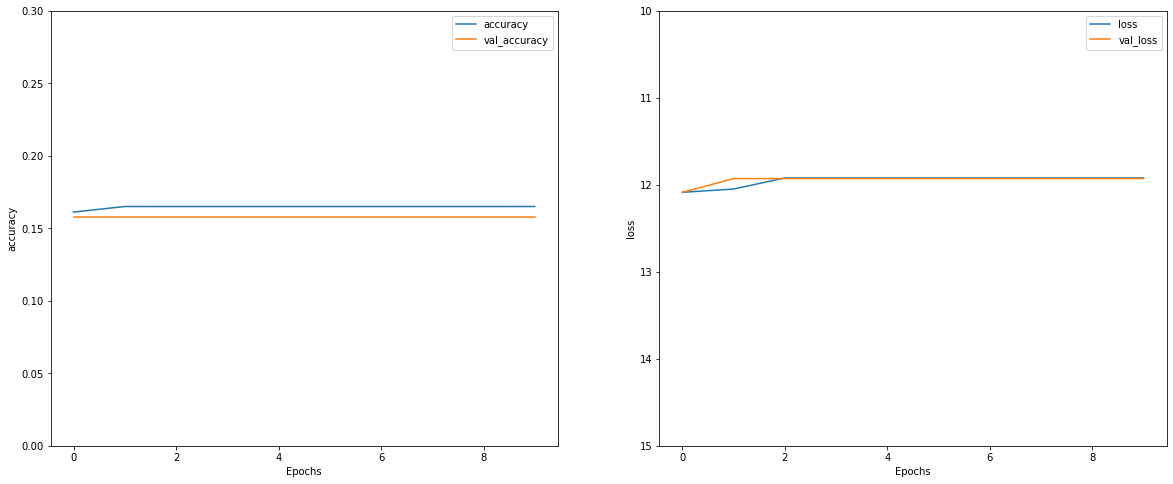

In [34]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(0,0.3)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(15, 10)